# Quickstart

`pyTDGL` solves a generalized time-depdendent Ginzburg-Landau (TDGL) equation for two-dimensional superconducting *device* with arbitrary geometry. At a high level, the TDGL model can be understood as a set of coupled partial differential equations (PDEs) describing the evolution of a complex field $\psi(\mathbf{r}, t)$ (the superconducting order parameter) and $\mu(\mathbf{r}, t)$ (the electric potential) in space and time.

The inputs to the model are:

1. Properties of the superconducting thin film: thickness $d$, Ginzburg-Landau coherence length $\xi$, and London penetration depth $\lambda$ (see `tdgl.Layer`).
2. The geometry of the device residing in the film, which can include holes (see `tdgl.Polygon`).
3. A time-independent applied magnetic vector potential $\mathbf{A}_\mathrm{applied}(\mathbf{r})$.
4. An applied bias current $I_\mathrm{source-drain}$, which flows into the device through a *source terminal* and out of the device through a *drain terminal*.

The outputs of the model are:

1. The complex order parameter $\psi(\mathbf{r}, t)=|\psi|e^{i\theta}$, where $|\psi|^2=n_s$ is the normalized superfluid density.
2. The electric scalar potential $\mu(\mathbf{r}, t)$, which arises from motion of vortices in the film.
3. The sheet current density in the device, $\mathbf{K}(\mathbf{r}, t)=\mathbf{K}_s(\mathbf{r}, t)+\mathbf{K}_n(\mathbf{r}, t)$, which is the sum of the sheet supercurrent density $\mathbf{K}_s$ and the sheet normal current density $\mathbf{K}_n$.

While the TDGL calculation is performed in dimensionless units, the inputs and outputs are specified in experimentalist-friendly physics units. The translation between the two is handled by the `tdgl.Device` class.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle

## Superconducting weak link

In [2]:
length_units = "um"
xi = 0.5
london_lambda = 2
d = 0.1

total_width = 5
total_length = 2.5 * total_width
link_width = total_width / 2

layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=0)
film = tdgl.Polygon("film", points=box(total_length, total_width))
notch = (
    tdgl.Polygon(points=box(total_width))
    .rotate(45)
    .translate(dy=(np.sqrt(2) * total_width + link_width) / 2)
)
film = film.difference(notch, notch.scale(yfact=-1))
source = tdgl.Polygon(
    "source",
    points=box(total_length / 100, 1.1 * total_width, center=(-total_length / 2, 0)),
)
drain = source.scale(xfact=-1).set_name("drain")
voltage_points = [(-total_length / 3, 0), (total_length / 3, 0)]

In [3]:
device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    terminals=[source, drain],
    voltage_points=voltage_points,
    length_units=length_units,
).rotate(-90)

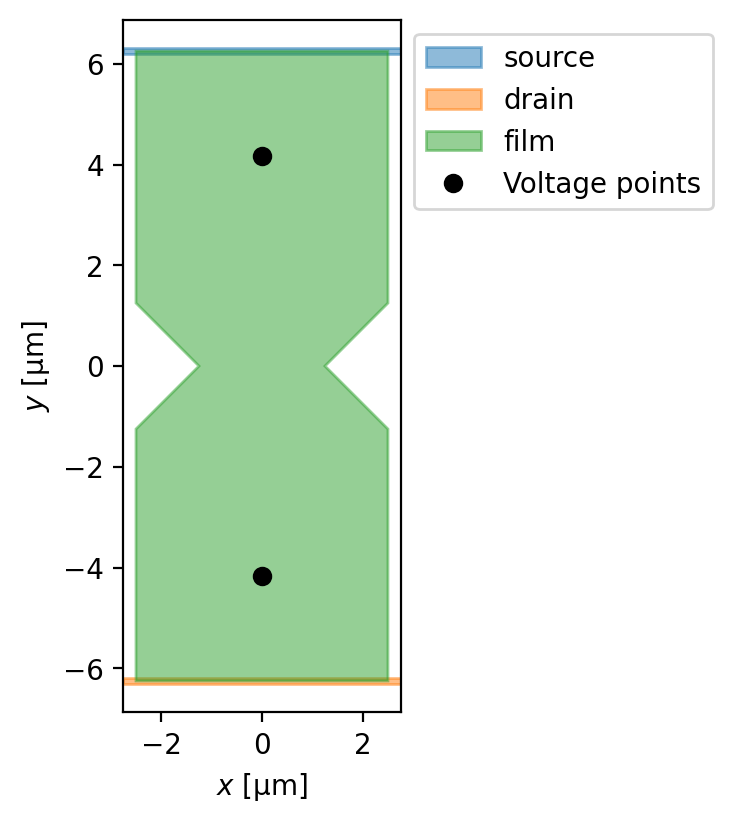

In [4]:
fig, ax = device.draw()

In [5]:
device.make_mesh(max_edge_length=xi / 2, optimesh_steps=40)

In [6]:
device.mesh_stats()

num_sites,6787
num_elements,13271
min_edge_length,6.893e-02
max_edge_length,2.083e-01
mean_edge_length,1.028e-01
min_area,2.396e-03
max_area,3.699e-02
mean_area,8.834e-03
coherence_length,5.000e-01
length_units,um


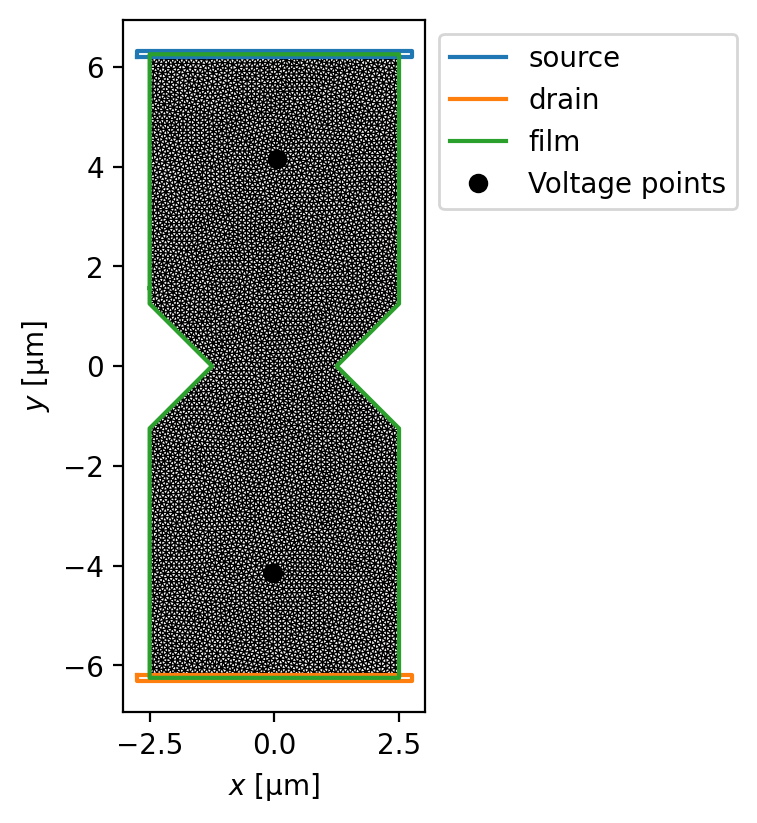

In [7]:
fig, ax = device.plot(mesh=True)

In [8]:
options = tdgl.SolverOptions(
    solve_time=200,
    adaptive=True,
    # dt_init=1e-4,
    # dt_max=0.01,
    skip_time=0,
    save_every=100,
    adaptive_window=10,
)

solution = tdgl.solve(
    device,
#     "data/weak-link.h5",
    options,
    terminal_currents=dict(source=20, drain=-20),
    current_units="uA",
    include_screening=False,
)

Simulating: 100%|███████████████████▉| 200/200 [00:05<00:00, 39.15tau/s ]


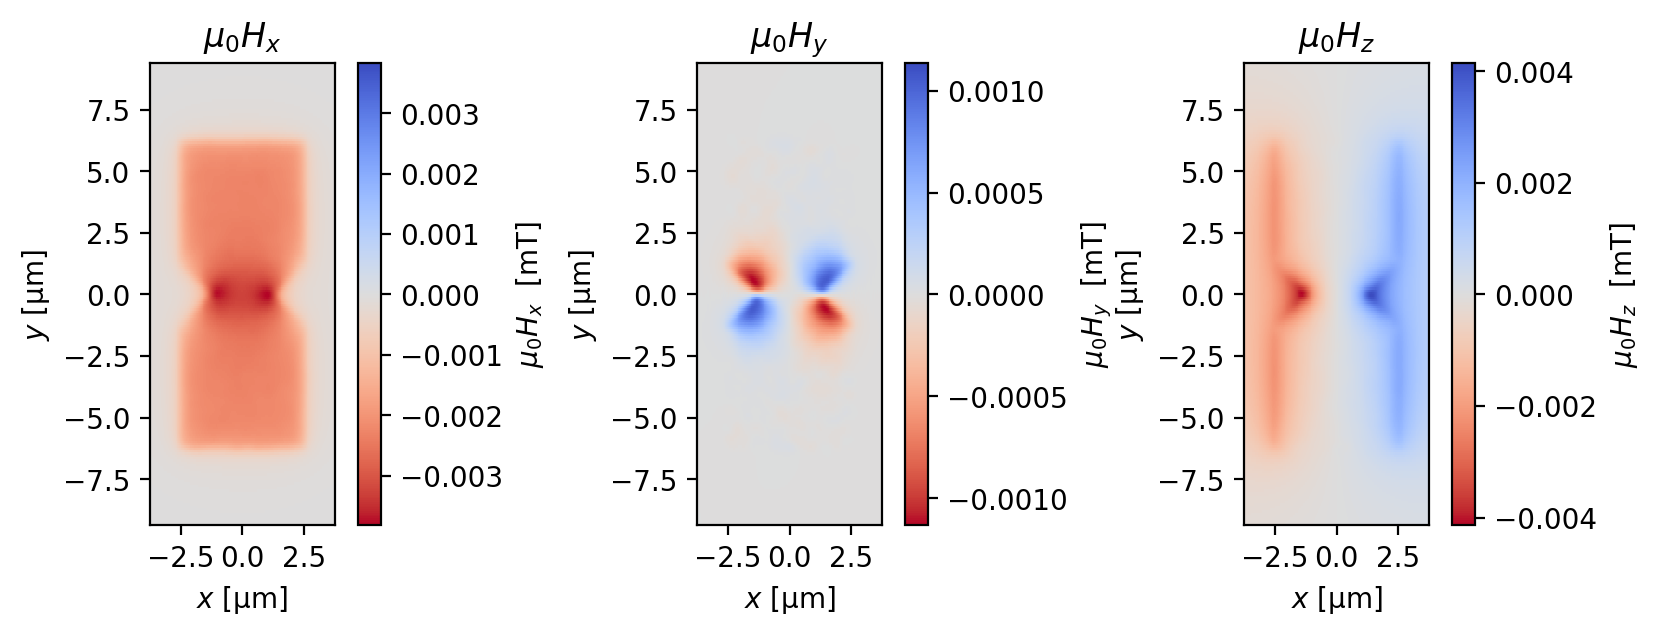

In [16]:
_ = solution.plot_field_at_positions(
    device.points * 1.5,
    zs=0.25, vector=True,
    symmetric_color_scale=True, cmap="coolwarm_r",
    figsize=(10, 3),
)

In [ ]:
fig, axes = solution.dynamics.plot(tmin=100)

In [ ]:
fig, ax = solution.dynamics.plot_dt()

In [ ]:
fig, ax = solution.plot_scalar_potential()

In [ ]:
fig, axes = solution.plot_order_parameter()

In [ ]:
total_time = 600

def terminal_currents(t, current=0, t0=total_time / 3):
    i = current * (t > t0)
    return dict(source=i, drain=-i)


options = tdgl.SolverOptions(
    dt_init=1e-4,
    dt_max=0.1,
    skip_time=0,
    solve_time=total_time,
    save_every=100,
)

solution = tdgl.solve(
    device,
#     "data/weak-link.h5",
    options,
    applied_vector_potential=tdgl.sources.ConstantField(1),
    field_units="mT",
    terminal_currents=lambda t: terminal_currents(t, current=5),
    current_units="uA",
)

In [ ]:
fig, axes = solution.plot_order_parameter()

In [ ]:
fig, axes = solution.dynamics.plot(t_min=300)

In [ ]:
options = tdgl.SolverOptions(
    dt_min=dt,
    dt_max=10 * dt,
    skip_time=0,
    total_time=200,
    save_every=100,
)

solution = tdgl.solve(
    device,
    "data/weak-link.h5",
    options,
    applied_vector_potential=tdgl.sources.ConstantField(1),
    field_units="mT",
    source_drain_current=5,
    current_units="uA",
    include_screening=False,
    seed_solution=solution,
)

In [ ]:
from tdgl.visualization import animate

In [ ]:
animate.MultiAnimate(
    solution.path,
    solution.path.replace(".h5", ".gif"),
    fps=15,
    dpi=400,
    observables=("complex_field", "phase", "supercurrent", "scalar_potential"),
    max_cols=2,
    full_title=True,
).build()

In [ ]:
ureg = tdgl.ureg

In [ ]:
(ureg("Phi_0") / (np.pi * ureg("250 nm")**2)).to("mT")

In [ ]:
bool(lambda x: x)

In [ ]:
np.clip(5, 2, 4)

In [ ]:
tuple(tuple())